# Práctica 2
**IDS330L, Feb-Abr 2023**

En continuación a la introducción a uno de los conceptos básicos de las implementación de inteligencia en las máquinas, veremos la aplicación más ventajosa de una neurona: combinar informaciones para tomar una decisión.

En este caso veremos: 
1. La organización de neuronas para tomar una decisión
2. El proceso de ajustar con una meta los pesos de la suma ponderada que lleva a cabo cada neurona
3. La implementación de un método de propagación de los ajustes para cambiar una serie de neuronas hacia un resultado esperado

Esto es, veremos cómo crear y entrenar una red neuronal para hacer un trabajo de clasificación, y las herramientas y procesos que lo permiten.

Está práctica está basada en las explicaciones del libro de (Planche & Andres, 2019) entre las páginas 31-47 y hará constantes referencias a este texto. 

Esta sección sigue los pasos mostrados en el notebook de acompañamiento al capítulo 1 del libro, que está publicado en https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/tree/master/Chapter01


In [1]:
import numpy as np

La ventaja de las neuronas es que convierten una serie de entradas en una sola salida que responde de acuerdo al estímulo combinado de sus entradas. Es decir, una neurona permite combinar 2 o más entradas para generar una salida, que hemos expresado como 

$$ z = x \cdot w + b $$

que es la implementación de un producto punto entre las entradas y los pesos (ganancias). 

Como explica el libro en la página 32, esta implementacion se puede expandir si se consideran varias neuronas que procesan cada una (en paralelo) las mismas $n$ entradas, pero con ganancias úncas para cada neurona. Esto es que 

$$ z_A = x \cdot w_A + b_A \\  z_B = x \cdot w_B + b_B  \\  z_C = x \cdot w_C + b_C $$

se puede resumir a 

$$ z = x \cdot W + B $$

donde $W$ y $B$ combinan los vectores de ganancias y bias de cada neurona. Note que la operación sigue siendo un producto punto. 

Esto implica que para un vector $x$ de entradas, se pueden crear $W$ y $B$ de forma que en una sola operación se computen las salidas $z$ de cada $n$ neuronas (ver página 33).

Más interesantemente, esto también puede expandirse para computar las salidas $z$ de **varios** vectores de entrada al mismo tiempo. Es decir, para computar las salidas de $n$ neuronas, se puede pasar un vector $x$ de tamaño $n x s$ ($s$ entradas) para generar un vector de salidas $z$ de tamaño $n x 1$ ($n$ salidas), sin tener que cambiar la manera en que se computan.

Esto quiere decir que con definir la versión matricial descrita arriba, se pueden implementar varias neuronas trabajando juntas para procesar una misma serie de entradas $x$ para generar una serie de salidas $z$, esencialmente implementando **una capa de neuronas** interconectadas entre ellas (todas interpretando la misma entrada y generando su propia salida). Esta es la base para las redes neuronales, que implementan varias capas de neuronas en serie que finalmente generan una salida que resume la interpretación de la entrada.

La clase mostrada abajo implementa una capa de neuronas interconectadas basada en la ecuación matricial de arriba. Si notan la diferencia esencial entre esta y la de la neurona simple es la forma en que se acepta un tamaño de la red (cantidad de neuronas).

In [2]:
class FullyConnectedLayer(object):
    """A simple fully-connected NN layer.
    Args:
        num_inputs (int): The input vector size / number of input values.
        layer_size (int): The output vector size / number of neurons in the layer.
        activation_function (callable): The activation function for this layer.
    Attributes:
        W (ndarray): The weight values for each input.
        b (ndarray): The bias value, added to the weighted sum.
        size (int): The layer size / number of neurons.
        activation_function (callable): The activation function computing the neuron's output.
        x (ndarray): The last provided input vector, stored for backpropagation.
        y (ndarray): The corresponding output, also stored for backpropagation.
    """

    def __init__(self, num_inputs, layer_size, activation_function, derivated_activation_function=None):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (using a normal distribution this time):
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size

        self.activation_function = activation_function
        self.derivated_activation_function = derivated_activation_function
        self.x, self.y = None, None
        self.dL_dW, self.dL_db = None, None

    def forward(self, x):
        """
        Forward the input vector through the layer, returning its activation vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`
        Returns:
            activation (ndarray): The activation value, of shape `(batch_size, layer_size)`.
        """
        z = np.dot(x, self.W) + self.b
        self.y = self.activation_function(z)
        self.x = x  # (we store the input and output values for back-propagation)
        return self.y


Probemos la habilidad de combinar entradas en una red de 3 neuronas donde cada una procesa las mismas 2 entradas. Luego alimentaremos dos grupos de entradas diferentes en una sola operación.

Primero generamos la red Y generamos las entradas.

In [3]:
input_size    = 2
num_neurons   = 3
relu_function = lambda y: np.maximum(y, 0)

layer = FullyConnectedLayer(num_inputs=input_size, layer_size=num_neurons, activation_function=relu_function)

In [4]:
x1 = np.random.uniform(-1, 1, 2).reshape(1, 2)
print("Input vector #1: {}".format(x1))
x2 = np.random.uniform(-1, 1, 2).reshape(1, 2)
print("Input vector #2: {}".format(x2))

Input vector #1: [[ 0.55260368 -0.61199843]]
Input vector #2: [[0.957762   0.49921351]]


Probamos la red con ada entrada:

In [5]:
y1 = layer.forward(x1)
print("Layer's output value given `x1` : {}".format(y1))

Layer's output value given `x1` : [[0. 0. 0.]]


In [6]:
y2 = layer.forward(x2)
print("Layer's output value given `x2` : {}".format(y2))

Layer's output value given `x2` : [[0.40417895 0.         0.        ]]


Y combinamos ambas entradas en una sola operación, para comparar los resultados.

In [7]:
x12 = np.concatenate((x1, x2))  # stack of input vectors, of shape `(2, 2)`
y12 = layer.forward(x12)
print("Layer's output value given `[x1, x2]` :\n{}".format(y12))

Layer's output value given `[x1, x2]` :
[[0.         0.         0.        ]
 [0.40417895 0.         0.        ]]


# Creando una red de neuronas

Esta vez, prepararemos una red capaz de reconocer los número 0-9 a partir de imágenes. Esto es, una red capaz de clasificar imágenes de acuerdo si la red interpreta que la imagen tiene un número entre el 0 y el 9. La forma en que esto ocurre es creando una red que acepte la imagen (sus pixeles) en su capa de entrada, y active solo una neurona en la capa de salida, que represente el valor del número. Esto es, que una neurona se activa si es un 1, otra se activa si es un 2, y así.

Combinar varias capas no es suficiente para hacer un trabajo, cada neurona necesita responder adecuadamente a los estímulos que recibe para que el resultado final sea el esperado. Sin embargo, predefinir el valor específico de cada ganancia puede llegar a ser imposible. Si no es así, lo que tenemos es una serie de capas de neuronas respondiendo aleatoriamente a los estímulo, ya que cada neurona se inicializa con valores aleatorios.

Sin embargo, podemos generar una red que haga un trabajo específico si conseguimos una manera de ir ajustando las ganancias apropiadamente según los resultados que veamos. Esto es entrenar una red neuronal y lo veremos abajo.

Basado en el cuaderno disponible por el libro.

Nuestro propósito es combinar varias capas (que pueden tener diferentes tamaños) para crear una **red neuronal** que nos permitirá realizar predicciones no lineales.

Aplicando el método de ***descenso de gradiente***, dicha red se puede entrenar para realizar predicciones correctas (ver la teoría en las páginas 38-42 del libro). Pero para eso, necesitamos definir una función de ***pérdida*** para evaluar el rendimiento de la red (cf. ***L2*** o pérdidas de ***entropía cruzada*** presentadas en el libro), y necesita saber cómo *derivar* todas las operaciones realizadas por la red, para calcular y propagar los gradientes entre las neuronas de cada red.

En esta sección, presentaremos cómo se puede construir una red neuronal simple completamente conectada. Supongamos que queremos que nuestra red use la función *sigmoide* para la activación. Necesitamos implementar esa función _y_ su derivada:

In [8]:
def sigmoid(x):             # sigmoid function
    y = 1 / (1 + np.exp(-x))
    return y


def derivated_sigmoid(y):   # sigmoid derivative function
    return y * (1 - y)

En una red para clasificación, pudieramos usar una función de pérdida tipo *L2* o de *entropía cruzada*, como explica el libro (pg. 40). Y se debe implementar la función *L2*, la de entropía y sus derivadas:

In [9]:
def loss_L2(pred, target):             # L2 loss function
    return np.sum(np.square(pred - target)) / pred.shape[0] # opt. we divide by the batch size


def derivated_loss_L2(pred, target):   # L2 derivative function
    return 2 * (pred - target)

In [10]:
def binary_cross_entropy(pred, target):            # cross-entropy loss function
    return -np.mean(np.multiply(np.log(pred), target) + np.multiply(np.log(1 - pred), (1 - target)))


def derivated_binary_cross_entropy(pred, target):  # cross-entropy derivative function
    return (pred - target) / (pred * (1 - pred))

Para entrenar la red, necesitamos darle la opción de poder actualizarse utilizando funciones de optimización e implementando un método de propagación reversa de los ajustes. La clase debajo lo actualiza la clase de Capa para tener esta habilidad.

In [11]:
class FullyConnectedLayer(object):
    """A simple fully-connected NN layer.
    Args:
        num_inputs (int): The input vector size / number of input values.
        layer_size (int): The output vector size / number of neurons in the layer.
        activation_function (callable): The activation function for this layer.
    Attributes:
        W (ndarray): The weight values for each input.
        b (ndarray): The bias value, added to the weighted sum.
        size (int): The layer size / number of neurons.
        activation_function (callable): The activation function computing the neuron's output.
        x (ndarray): The last provided input vector, stored for backpropagation.
        y (ndarray): The corresponding output, also stored for backpropagation.
        derivated_activation_function (callable): The corresponding derivated function for backpropagation.
        dL_dW (ndarray): The derivative of the loss, with respect to the weights W.
        dL_db (ndarray): The derivative of the loss, with respect to the bias b.
    """

    def __init__(self, num_inputs, layer_size, activation_function, derivated_activation_function=None):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (using a normal distribution this time):
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size

        self.activation_function = activation_function
        self.derivated_activation_function = derivated_activation_function
        self.x, self.y = None, None
        self.dL_dW, self.dL_db = None, None

    def forward(self, x):
        """
        Forward the input vector through the layer, returning its activation vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`
        Returns:
            activation (ndarray): The activation value, of shape `(batch_size, layer_size)`.
        """
        z = np.dot(x, self.W) + self.b
        self.y = self.activation_function(z)
        self.x = x  # (we store the input and output values for back-propagation)
        return self.y

    def backward(self, dL_dy):
        """
        Back-propagate the loss, computing all the derivatives, storing those w.r.t. the layer parameters,
        and returning the loss w.r.t. its inputs for further propagation.
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the layer's output (dL/dy = l'_{k+1}).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the layer's input (dL/dx).
        """
        dy_dz = self.derivated_activation_function(self.y)  # = f'
        dL_dz = (dL_dy * dy_dz) # dL/dz = dL/dy * dy/dz = l'_{k+1} * f'
        dz_dw = self.x.T
        dz_dx = self.W.T
        dz_db = np.ones(dL_dy.shape[0]) # dz/db = d(W.x + b)/db = 0 + db/db = "ones"-vector

        # Computing the derivatives with respect to the layer's parameters, and storing them for opt. optimization:
        self.dL_dW = np.dot(dz_dw, dL_dz)
        self.dL_db = np.dot(dz_db, dL_dz)

        # Computing the derivative with respect to the input, to be passed to the previous layers (their `dL_dy`):
        dL_dx = np.dot(dL_dz, dz_dx)
        return dL_dx

    def optimize(self, epsilon):
        """
        Optimize the layer's parameters, using the stored derivative values.
        Args:
            epsilon (float): The learning rate.
        """
        self.W -= epsilon * self.dL_dW
        self.b -= epsilon * self.dL_db  

## Implementación de la red

Para crear la red, usamos una clase que implemente diferente capas de neuronas y las funciones para pasar la información por cada red.

Esta red necesitará poder realizar los cálculos necesarios para definir los ajustes de las ganancias en cada neurona, y propagarlas hasta alcanzar cada una.

In [12]:
class SimpleNetwork(object):
    """A simple fully-connected NN.
    Args:
        num_inputs (int): The input vector size / number of input values.
        num_outputs (int): The output vector size.
        hidden_layers_sizes (list): A list of sizes for each hidden layer to add to the network
        activation_function (callable): The activation function for all the layers
        derivated_activation_function (callable): The derivated activation function
        loss_function (callable): The loss function to train this network
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation
    Attributes:
        layers (list): The list of layers forming this simple network.
        loss_function (callable): The loss function to train this network.
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation.
    """

    def __init__(self, num_inputs, num_outputs, hidden_layers_sizes=(64, 32),
                 activation_function=sigmoid, derivated_activation_function=derivated_sigmoid,
                 loss_function=loss_L2, derivated_loss_function=derivated_loss_L2):
        super().__init__()
        # We build the list of layers composing the network, according to the provided arguments:
        layer_sizes = [num_inputs, *hidden_layers_sizes, num_outputs]
        self.layers = [
            FullyConnectedLayer(layer_sizes[i], layer_sizes[i + 1], 
                                activation_function, derivated_activation_function)
            for i in range(len(layer_sizes) - 1)]

        self.loss_function = loss_function
        self.derivated_loss_function = derivated_loss_function

    def forward(self, x):
        """
        Forward the input vector through the layers, returning the output vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`.
        Returns:
            activation (ndarray): The output activation value, of shape `(batch_size, layer_size)`.
        """
        for layer in self.layers: # from the input layer to the output one
            x = layer.forward(x)
        return x

    def predict(self, x):
        """
        Compute the output corresponding to input `x`, and return the index of the largest 
        output value.
        Args:
            x (ndarray): The input vector, of shape `(1, num_inputs)`.
        Returns:
            best_class (int): The predicted class ID.
        """
        estimations = self.forward(x)
        best_class = np.argmax(estimations)
        return best_class

    def backward(self, dL_dy):
        """
        Back-propagate the loss hrough the layers (require `forward()` to be called before).
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the network's output (dL/dy).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the network's input (dL/dx).
        """
        for layer in reversed(self.layers): # from the output layer to the input one
            dL_dy = layer.backward(dL_dy)
        return dL_dy

    def optimize(self, epsilon):
        """
        Optimize the network parameters according to the stored gradients (require `backward()`
        to be called before).
        Args:
            epsilon (float): The learning rate.
        """
        for layer in self.layers:             # the order doesn't matter here
            layer.optimize(epsilon)

    def evaluate_accuracy(self, X_val, y_val):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
        Returns:
            accuracy (float): The accuracy of the network 
                              (= number of correct predictions/dataset size).
        """
        num_corrects = 0
        for i in range(len(X_val)):
            pred_class = self.predict(X_val[i])
            if pred_class == y_val[i]:
                num_corrects += 1
        return num_corrects / len(X_val)

    def train(self, X_train, y_train, X_val=None, y_val=None, 
              batch_size=32, num_epochs=5, learning_rate=1e-3, print_frequency=20):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_train (ndarray): The input training dataset.
            y_train (ndarray): The corresponding ground-truth training dataset.
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
            batch_size (int): The mini-batch size.
            num_epochs (int): The number of training epochs i.e. iterations over the whole dataset.
            learning_rate (float): The learning rate to scale the derivatives.
            print_frequency (int): Frequency to print metrics (in epochs).
        Returns:
            losses (list): The list of training losses for each epoch.
            accuracies (list): The list of validation accuracy values for each epoch.
        """
        num_batches_per_epoch = len(X_train) // batch_size
        do_validation = X_val is not None and y_val is not None
        losses, accuracies = [], []
        for i in range(num_epochs): # for each training epoch
            epoch_loss = 0
            for b in range(num_batches_per_epoch):  # for each batch composing the dataset
                # Get batch:
                batch_index_begin = b * batch_size
                batch_index_end = batch_index_begin + batch_size
                x = X_train[batch_index_begin: batch_index_end]
                targets = y_train[batch_index_begin: batch_index_end]
                # Optimize on batch:
                predictions = y = self.forward(x)  # forward pass
                L = self.loss_function(predictions, targets)  # loss computation
                dL_dy = self.derivated_loss_function(predictions, targets)  # loss derivation
                self.backward(dL_dy)  # back-propagation pass
                self.optimize(learning_rate)  # optimization of the NN
                epoch_loss += L

            # Logging training loss and validation accuracy, to follow the training:
            epoch_loss /= num_batches_per_epoch
            losses.append(epoch_loss)
            if do_validation:
                accuracy = self.evaluate_accuracy(X_val, y_val)
                accuracies.append(accuracy)
            else:
                accuracy = np.NaN
            if i % print_frequency == 0 or i == (num_epochs - 1):
                print("Epoch {:4d}: training loss = {:.6f} | val accuracy = {:.2f}%".format(
                    i, epoch_loss, accuracy * 100))
        return losses, accuracies

Para nuestra tarea de clasificación, utilizaremos el [conjunto de datos MNIST](http://yann.lecun.com/exdb/mnist) presentado en el libro (Yann LeCun y Corinna Cortes tienen todos derechos de autor para este conjunto de datos).

Antes de implementar una solución, debemos preparar los datos, cargando las imágenes MNIST para los métodos de entrenamiento y prueba. Para simplificar, usaremos el módulo Python [`mnist`](https://github.com/datapythonista/mnist) desarrollado por [Marc Garcia](https://github.com/datapythonista), y suplido junto a este cuaderno (ver [`./mnist/`](mnist/__init__.py)).

In [13]:
%matplotlib inline
# !pip install matplotlib  # Uncomment and run if matplotlib is not installed yet.
import matplotlib          # We use this package to visualize some data and results
import matplotlib.pyplot as plt
import mnist

np.random.seed(42)

In [330]:
X_train, y_train = mnist.train_images(), mnist.train_labels()
X_test,  y_test  = mnist.test_images(), mnist.test_labels()
num_classes = 10    # classes are the digits from 0 to 9

Las imágenes tienen 28x28 pixeles cada una.

In [308]:
X_train.shape

(60000, 28, 28)

In [309]:
print(X_train.shape[2])

28


In [310]:
X_test.shape

(10000, 28, 28)

Ejemplo de una de las imágenes.

7270


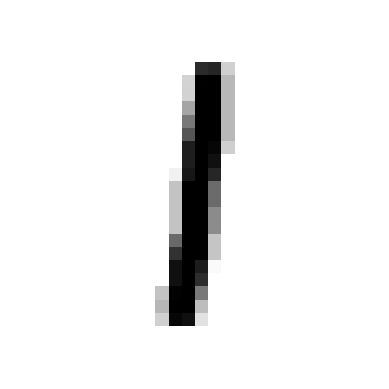

In [328]:
img_idx = np.random.randint(0, X_test.shape[0])
print(img_idx)
plt.imshow(X_test[img_idx], cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()

In [312]:
y_test[img_idx]

1

Como podemos ver, nuestras imágenes coinciden con su etiqueta de verdad sobre el terreno, ¡lo cual es una buena noticia!

Sin embargo, como nuestra red solo acepta vectores de columna, necesitamos _aplanar_ las imágenes en vectores 1D, es decir, vectores de forma `(1, 784)` (ya que $28 \times 28 = 784$):

In [287]:

X_train, X_test = X_train.reshape(-1, 28 * 28), X_test.reshape(-1, 28 * 28)

In [288]:
print("Pixel values between {} and {}".format(X_train.min(), X_train.max()))

Pixel values between 0 and 255


In [289]:
X_train, X_test = X_train / 255., X_test / 255.
print("Normalized pixel values between {} and {}".format(X_train.min(), X_train.max()))

Normalized pixel values between 0.0 and 1.0


In [290]:
y_train = np.eye(num_classes)[y_train] 

## Preparación del clasificador

Es hora de preparar el propio clasificador. Usemos nuestra clase `SimpleNetwork` e instanciamos una red con 2 capas ocultas, tomando una imagen aplanada como entrada y devolviendo un vector de 10 valores que representa su creencia de que la imagen pertenece a cada una de las clases (cuanto mayor sea el valor, más fuerte será la creencia):

In [291]:
print(X_train.shape[1])
print(X_train)
mnist_classifier = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, hidden_layers_sizes=[64, 32])

784
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [292]:
predictions = mnist_classifier.forward(X_train)                         # forward pass
loss_untrained = mnist_classifier.loss_function(predictions, y_train)   # loss computation

accuracy_untrained = mnist_classifier.evaluate_accuracy(X_test, y_test)  # Accuracy
print("Untrained : training loss = {:.6f} | val accuracy = {:.2f}%".format(
    loss_untrained, accuracy_untrained * 100))

Untrained : training loss = 4.436700 | val accuracy = 12.19%


In [56]:
losses, accuracies = mnist_classifier.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=60) #500
# note: Reduce the batch size and/or number of epochs if your computer can't 
#       handle the computations / takes too long.
#       Remember, numpy also uses the CPU, not GPUs as modern Deep Learning 
#       libraries do, hence the lack of computational performance here.

Epoch    0: training loss = 1.096978 | val accuracy = 19.10%
Epoch   20: training loss = 0.252953 | val accuracy = 84.89%
Epoch   40: training loss = 0.177532 | val accuracy = 88.92%
Epoch   59: training loss = 0.147752 | val accuracy = 90.37%


In [57]:
# We use `np.expand_dims(x, 0)` to simulate a batch (transforming the image shape
# from (784,) to (1, 784)):
predicted_class = mnist_classifier.predict(np.expand_dims(X_test[img_idx], 0))
print('Predicted class: {}; Correct class: {}'.format(predicted_class, y_test[img_idx]))

Predicted class: 1; Correct class: 1


# Ejercicio

1. Cree una versión de la red y córrala sin entrenar con unas 8 imágenes elegidas aleatoriamente.
2. Entrene la red hasta 80, 100 y 140 `epochs` y pruébela cada versión con las mismas 8 imágenes seleccionadas para el punto anterior.
3. Cambie el número de `batch_size` (mayor o menor, según la capacidad de su computador) y repita el ejercicio.
4. Escriba sus conclusiones sobre el efecto que tiene cambiar estos dos valores.

#### Cree una versión de la red y córrala sin entrenar con unas 8 imágenes elegidas aleatoriamente.

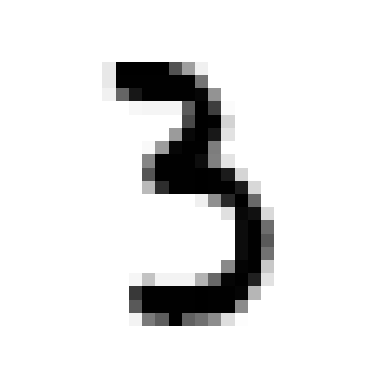

3


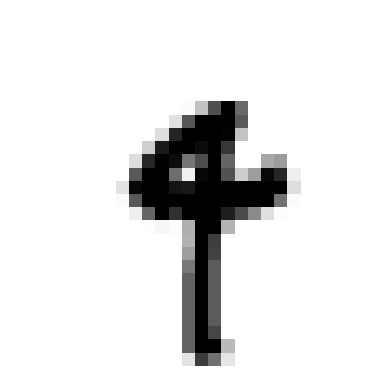

4


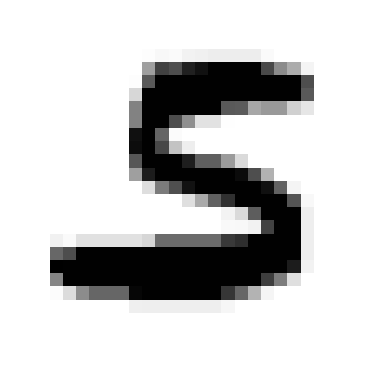

5


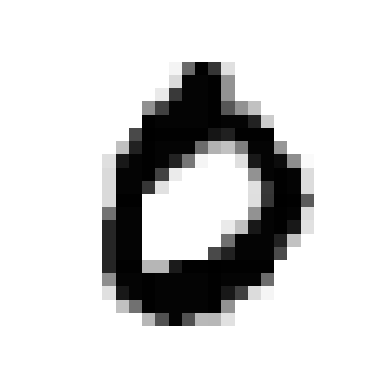

0


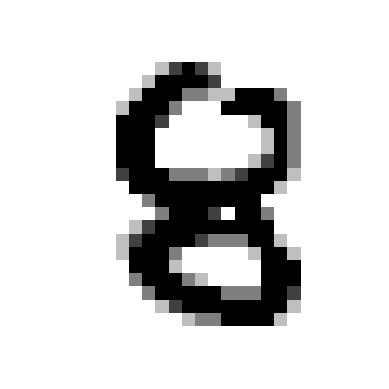

8


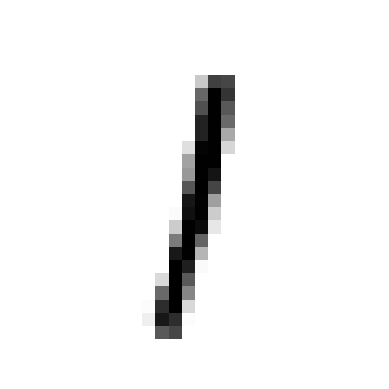

1


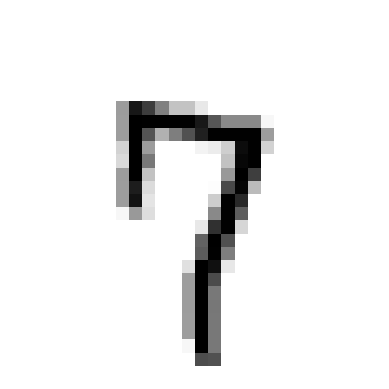

7


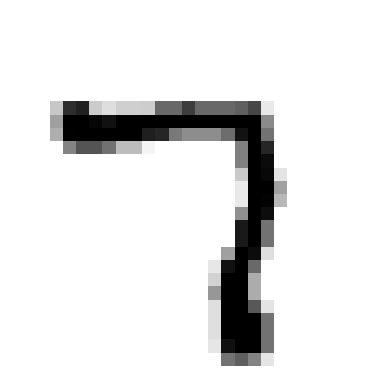

7
Predicted class: 9; Correct class: 3
Predicted class: 6; Correct class: 4
Predicted class: 9; Correct class: 5
Predicted class: 6; Correct class: 0
Predicted class: 9; Correct class: 8
Predicted class: 6; Correct class: 1
Predicted class: 3; Correct class: 7
Predicted class: 9; Correct class: 7
Untrained : training loss = 3.517540 | val accuracy = 8.00%


In [18]:
X_train, y_train = mnist.train_images(), mnist.train_labels()
X_test,  y_test  = mnist.test_images(), mnist.test_labels()
num_classes = 10    # classes are the digits from 0 to 9
random_indices = np.random.choice(X_test.shape[0], size=8, replace=False)
random_images = X_train[random_indices]
for random_imgx in random_indices:
    plt.imshow(X_test[random_imgx], cmap=matplotlib.cm.binary)
    plt.axis("off")
    plt.show()
    print(y_test[random_imgx])
X_train, X_test = X_train.reshape(-1, 28 * 28), X_test.reshape(-1, 28 * 28)
X_train, X_test = X_train / 255., X_test / 255.
y_train = np.eye(num_classes)[y_train] 
mnist_classifierTest = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, hidden_layers_sizes=[64, 32])
predictionsTest = mnist_classifierTest.forward(X_train)                         # forward pass
loss_untrainedTest = mnist_classifierTest.loss_function(predictionsTest, y_train)   # loss computation
for random_imgx in random_indices:
    predicted_classTest = mnist_classifierTest.predict(np.expand_dims(X_test[random_imgx], 0))
    print('Predicted class: {}; Correct class: {}'.format(predicted_classTest, y_test[random_imgx]))

accuracy_untrainedTest = mnist_classifierTest.evaluate_accuracy(X_test, y_test)  # Accuracy
print("Untrained : training loss = {:.6f} | val accuracy = {:.2f}%".format(
    loss_untrainedTest, accuracy_untrainedTest * 100))

#### Entrene la red hasta 80, 100 y 140 `epochs` y pruébela cada versión con las mismas 8 imágenes seleccionadas para el punto anterior.


#### Epoch 80

In [19]:
losses, accuracies = mnist_classifierTest.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=80)
predictionsTest = mnist_classifierTest.forward(X_train)                         # forward pass
loss_untrainedTest = mnist_classifierTest.loss_function(predictionsTest, y_train)   # loss computation
for random_imgx in random_indices:
    predicted_classTest = mnist_classifierTest.predict(np.expand_dims(X_test[random_imgx], 0))
    print('Predicted class: {}; Correct class: {}'.format(predicted_classTest, y_test[random_imgx]))

Epoch    0: training loss = 0.954241 | val accuracy = 32.61%
Epoch   20: training loss = 0.236984 | val accuracy = 85.97%
Epoch   40: training loss = 0.170953 | val accuracy = 89.38%
Epoch   60: training loss = 0.143559 | val accuracy = 90.87%
Epoch   79: training loss = 0.127967 | val accuracy = 91.80%
Predicted class: 3; Correct class: 3
Predicted class: 9; Correct class: 4
Predicted class: 2; Correct class: 5
Predicted class: 0; Correct class: 0
Predicted class: 8; Correct class: 8
Predicted class: 1; Correct class: 1
Predicted class: 7; Correct class: 7
Predicted class: 7; Correct class: 7


#### Epoch 100

In [21]:
losses, accuracies = mnist_classifierTest.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=100)
predictionsTest = mnist_classifierTest.forward(X_train)                         # forward pass
loss_untrainedTest = mnist_classifierTest.loss_function(predictionsTest, y_train)   # loss computation
for random_imgx in random_indices:
    predicted_classTest = mnist_classifierTest.predict(np.expand_dims(X_test[random_imgx], 0))
    print('Predicted class: {}; Correct class: {}'.format(predicted_classTest, y_test[random_imgx]))

Epoch    0: training loss = 0.087725 | val accuracy = 93.59%
Epoch   20: training loss = 0.083203 | val accuracy = 93.69%
Epoch   40: training loss = 0.079191 | val accuracy = 93.92%
Epoch   60: training loss = 0.075638 | val accuracy = 94.03%
Epoch   80: training loss = 0.072443 | val accuracy = 94.11%
Epoch   99: training loss = 0.069666 | val accuracy = 94.21%
Predicted class: 3; Correct class: 3
Predicted class: 9; Correct class: 4
Predicted class: 5; Correct class: 5
Predicted class: 0; Correct class: 0
Predicted class: 8; Correct class: 8
Predicted class: 1; Correct class: 1
Predicted class: 7; Correct class: 7
Predicted class: 7; Correct class: 7


#### Epoch 140

In [22]:
losses, accuracies = mnist_classifierTest.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=140)
predictionsTest = mnist_classifierTest.forward(X_train)                         # forward pass
loss_untrainedTest = mnist_classifierTest.loss_function(predictionsTest, y_train)   # loss computation
for random_imgx in random_indices:
    predicted_classTest = mnist_classifierTest.predict(np.expand_dims(X_test[random_imgx], 0))
    print('Predicted class: {}; Correct class: {}'.format(predicted_classTest, y_test[random_imgx]))

Epoch    0: training loss = 0.069526 | val accuracy = 94.21%
Epoch   20: training loss = 0.066846 | val accuracy = 94.30%
Epoch   40: training loss = 0.064386 | val accuracy = 94.38%
Epoch   60: training loss = 0.062118 | val accuracy = 94.49%
Epoch   80: training loss = 0.060021 | val accuracy = 94.50%
Epoch  100: training loss = 0.058073 | val accuracy = 94.55%
Epoch  120: training loss = 0.056261 | val accuracy = 94.62%
Epoch  139: training loss = 0.054648 | val accuracy = 94.64%
Predicted class: 3; Correct class: 3
Predicted class: 9; Correct class: 4
Predicted class: 5; Correct class: 5
Predicted class: 0; Correct class: 0
Predicted class: 8; Correct class: 8
Predicted class: 1; Correct class: 1
Predicted class: 7; Correct class: 7
Predicted class: 7; Correct class: 7


#### Cambie el número de `batch_size` (mayor o menor, según la capacidad de su computador) y repita el ejercicio.


Disminuir mi batch_size a 20

In [23]:
losses, accuracies = mnist_classifierTest.train(X_train, y_train, X_test, y_test, 
                                            batch_size=20, num_epochs=140)
predictionsTest = mnist_classifierTest.forward(X_train)                         # forward pass
loss_untrainedTest = mnist_classifierTest.loss_function(predictionsTest, y_train)   # loss computation
for random_imgx in random_indices:
    predicted_classTest = mnist_classifierTest.predict(np.expand_dims(X_test[random_imgx], 0))
    print('Predicted class: {}; Correct class: {}'.format(predicted_classTest, y_test[random_imgx]))

Epoch    0: training loss = 0.054563 | val accuracy = 94.64%
Epoch   20: training loss = 0.052968 | val accuracy = 94.67%
Epoch   40: training loss = 0.051477 | val accuracy = 94.69%
Epoch   60: training loss = 0.050088 | val accuracy = 94.71%
Epoch   80: training loss = 0.048788 | val accuracy = 94.71%
Epoch  100: training loss = 0.047562 | val accuracy = 94.74%
Epoch  120: training loss = 0.046402 | val accuracy = 94.74%
Epoch  139: training loss = 0.045357 | val accuracy = 94.77%
Predicted class: 3; Correct class: 3
Predicted class: 9; Correct class: 4
Predicted class: 5; Correct class: 5
Predicted class: 0; Correct class: 0
Predicted class: 8; Correct class: 8
Predicted class: 1; Correct class: 1
Predicted class: 7; Correct class: 7
Predicted class: 7; Correct class: 7


#### Escriba sus conclusiones sobre el efecto que tiene cambiar estos dos valores.

En conclusión, pude entender que Batch_size es la cantidad de ejemplos que se procesa para entrenar la red neuronal y el epoch es el número de veces que el modelo ha visto todo el conjunto de entrenamiento. En este caso los ejemplos con los cuales se esta entrenando son imagenes, sacada de una base de datos de 60,000 imagenes.

Dado esta información se puede concluir que mientras mas epoch tengas y mas batch_size mas tiempo durara procesando todo el conjunto.

Otra cosa que se puede recalcar de esta tarea es que mientras mas entrena, la precisión el avance de la precisión es cada vez menor.
